In [2]:
import numpy as np
import tensorflow as tf
import keras as k
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


In [3]:


def load_dataset(path:str, squeeze=False):
    with open(path, 'rb') as f:
        d = np.load(f, allow_pickle=True)
        X_train = d['X_train']
        y_train = d['y_train']
        X_test = d['X_test']
        y_test = d['y_test']

    if squeeze:
        X_train = np.squeeze(X_train)
        X_test = np.squeeze(X_test)

    return (X_train,y_train,X_test,y_test)

In [4]:
X_train_raw, y_train_raw, X_test, y_test = load_dataset('regression_popularity.npz')

## Il Modello

In [5]:
class MLP_reg(k.Model):
  def __init__(self):
    super().__init__()

    self.dense1 = l.Dense(128 ,activation='relu')
    self.batchnorm1 = l.BatchNormalization(axis=-1)

    self.dense2 = l.Dense(256, activation='relu', kernel_regularizer=k.regularizers.l2(0.08))
    self.batchnorm2 = l.BatchNormalization(axis=-1)

    self.dense3 = l.Dense(512, activation='relu', kernel_regularizer=k.regularizers.l2(0.08))
    self.batchnorm3 = l.BatchNormalization(axis=-1)

    self.dense4 = l.Dense(256, activation='relu', kernel_regularizer=k.regularizers.l2(0.08))
    self.batchnorm4 = l.BatchNormalization(axis=-1)

    self.out = l.Dense(1, activation='sigmoid', kernel_regularizer=k.regularizers.l2(0.05))

    self.drop = l.Dropout(0.5)

  def call(self, x):
    # layer 1
    x = self.dense1(x)
    x = self.batchnorm1(x)
    self.drop(x)

    x1 = tf.identity(x)

    # layer 2
    x = self.dense2(x)
    x = self.batchnorm2(x)
    self.drop(x)

    x2 = tf.identity(x)

    # layer 3
    x = tf.concat([x, x1], axis=1)
    x = self.dense3(x)
    x = self.batchnorm3(x)
    self.drop(x)


    # layer 4
    x = tf.concat([x, x2], axis=1)
    x = self.dense4(x)
    x = self.batchnorm4(x)
    self.drop(x)




    # layer out
    x = x + x2
    x = self.out(x)

    return x

lo carico già addestrato

In [6]:
model = tf.saved_model.load('pop_reg_mod')

## Training Plots

In [9]:
train_r2 = np.load('logs_reg.npz')['tot_acc']
train_loss = np.load('logs_reg.npz')['tot_train_loss']
val_r2 = np.load('logs_reg.npz')['tot_val_acc']
val_loss = np.load('logs_reg.npz')['tot_val_loss']

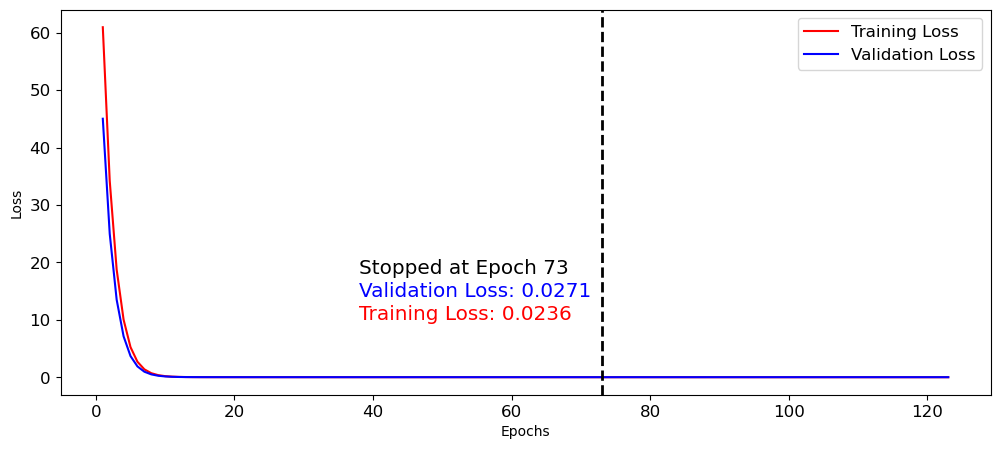

In [18]:
epochs = range(1, len(val_r2)+1)

plt.figure(figsize=(12,5))
plt.plot(epochs, train_loss, label='Training Loss', c='red')
plt.plot(epochs, val_loss, label='Validation Loss', c='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(fontsize='large')
plt.axvline(x=np.argmax(val_r2)+1, c='black', linestyle='--', linewidth=2)


plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=10)

plt.text(x=np.argmax(val_r2)-34, y=18, s=f'Stopped at Epoch {np.argmax(val_r2)+1}', fontsize='x-large')
plt.text(x=np.argmax(val_r2)-34, y=14, s=f'Validation Loss: {round(val_loss[np.argmax(val_r2)], 4)}', c='blue', fontsize='x-large')
plt.text(x=np.argmax(val_r2)-34, y=10, s=f'Training Loss: {round(train_loss[np.argmax(val_r2)], 4)}', c='red', fontsize='x-large')
plt.show()

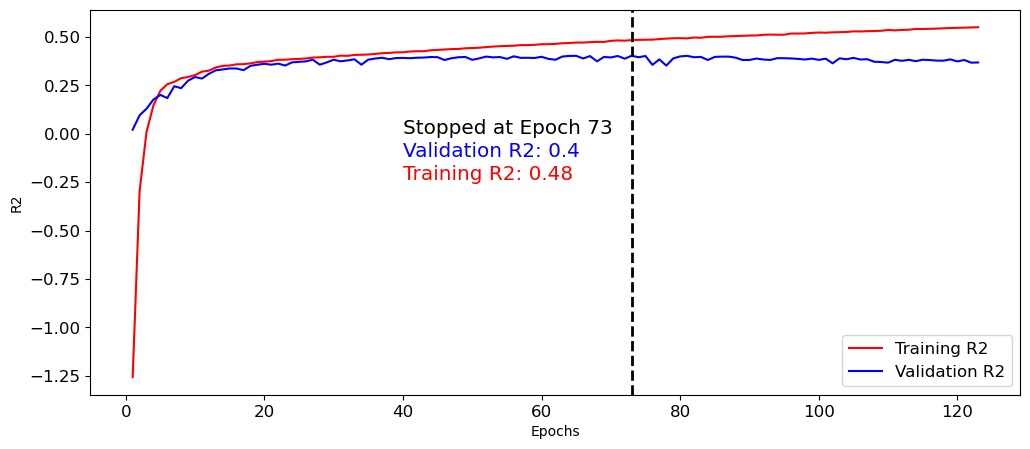

In [24]:
plt.figure(figsize=(12,5))
plt.plot(epochs, train_r2, label='Training R2', c='red')
plt.plot(epochs, val_r2, label='Validation R2', c='blue')
plt.xlabel('Epochs')
plt.ylabel('R2')
plt.legend(fontsize='large')
plt.axvline(x=np.argmax(val_r2)+1, c='black', linestyle='--', linewidth=2)

plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=10)

plt.text(x=np.argmax(val_r2)-32, y=0, s=f'Stopped at Epoch {np.argmax(val_r2)+1}', fontsize='x-large')
plt.text(x=np.argmax(val_r2)-32, y=-0.12, s=f'Validation R2: {round(val_r2[np.argmax(val_r2)], 2)}', c='blue', fontsize='x-large')
plt.text(x=np.argmax(val_r2)-32, y=-0.24, s=f'Training R2: {round(train_r2[np.argmax(val_r2)], 2)}', c='red', fontsize='x-large')
plt.show()

## Test

In [25]:
y_pred= model.serve(X_test).numpy()

In [26]:
print(f'R2: {r2_score(y_test, y_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')

R2: 0.39871501404870435
MSE: 0.025347703550896404
MAE: 0.11354209058654822
